In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
import os
import glob
from sklearn import preprocessing
from pysptools import spectro as sp
from pysptools import distance
from IPython.display import display
import ipywidgets as widgets
from math import*
from ipywidgets import IntProgress
from scipy.fft import fft, fftfreq, fftshift

In [2]:
### https://dataaspirant.com/five-most-popular-similarity-measures-implementation-in-python/
### https://towardsdatascience.com/four-ways-to-quantify-synchrony-between-time-series-data-b99136c4a9c9

class Widegets:
    def on_value_change_min(change):
        new_min = change['new']
        #print(change['name'])
        if new_min + 100 > maxWavelength.value:
            minWavelength.value = maxWavelength.value - 100

    def on_value_change_max(change):
        new_max = change['new']
        if minWavelength.value > new_max - 100:
            maxWavelength.value = minWavelength.value + 100
        
class FolderAndFileProcessing:
    def ReadFilePaths(source, ext):
        return glob.glob(source + "/**/*." + ext, recursive = True)
    
    def ReadFile(file, rowToSkip, seperation):
        return pd.read_csv(file ,skiprows = rowToSkip, sep = seperation) 
    
    def GetValuesFromFile(file, rowToSkip, seperation, column):
        fileData = FolderAndFileProcessing.ReadFile(file , rowToSkip, seperation)
        return fileData[column]
    
    def WriteDictToExcel(targetPath, filename, dictionary):
        df = pd.DataFrame.from_dict(dictionary)
        os.makedirs(targetPath, exist_ok=True)
        df.to_excel(targetPath+filename)
    
    def combine_dicts(a, b):
        for key in b:
            if key in a:
                b[key] = b[key] + a[key]
        c = {**a, **b}
        return c
        
class SpectraComparision:
    
    def MeanSquareRootComparision(fileList, spectraValue, minIndex, maxIndex):
        mineralScore = {}
        for index in range(len(fileList)):
            idealReflectance = FolderAndFileProcessing.GetValuesFromFile(fileList[index], 0, ' ','reflectance')
            result = spectraValue[minIndex:maxIndex] - idealReflectance[minIndex:maxIndex]
            score = np.sqrt(np.mean(result**2))
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore
    
    def MeanSquareRootComparisionNormalized(fileList, spectraValue, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        for index in range(len(fileList)):
            idealReflectance = FolderAndFileProcessing.GetValuesFromFile(fileList[index], 0, ' ','reflectance')
            #print(idealReflectance, fileList[index])
            normalized_idealReflectance = preprocessing.normalize([idealReflectance])[0]
            result = normalized_spectraValue[minIndex:maxIndex] - normalized_idealReflectance[minIndex:maxIndex]
            score = np.sqrt(np.mean(result**2))
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore
    
    def CrossCorrelation(fileList, spectraValue, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        for index in range(len(fileList)):
            idealReflectance = FolderAndFileProcessing.GetValuesFromFile(fileList[index], 0, ' ','reflectance')
            normalized_idealReflectance = preprocessing.normalize([idealReflectance])[0]
            result = np.corrcoef(normalized_spectraValue[minIndex:maxIndex], normalized_idealReflectance[minIndex:maxIndex])
            score = result[0, 1]
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore
    
    def CrossCorrelationContinumRemoved(fileList, spectraValue, minIndex, maxIndex):
        mineralScore = {}
        waveLength = list(range(350,2501))
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        for index in range(len(fileList)):
            idealReflectance = FolderAndFileProcessing.GetValuesFromFile(fileList[index], 0, ' ','reflectance')
            normalized_idealReflectance = preprocessing.normalize([idealReflectance])[0]
            continumRemoved_idealReflectance = sp.convex_hull_removal(normalized_idealReflectance, waveLength)[0]
            result = np.corrcoef(continumRemoved_spectraValue[minIndex:maxIndex], continumRemoved_idealReflectance[minIndex:maxIndex])
            score = result[0, 1]
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore
    
    def CrossCorrelationContinumRemovedFaster(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            result = np.corrcoef(continumRemoved_spectraValue[minIndex:maxIndex], continumRemoved_idealReflectance[minIndex:maxIndex])
            score = result[0, 1]
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1], reverse=True)
        return mineralScore
    
    def MeanSquareRootContinumRemovedFaster(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            result = np.array(continumRemoved_spectraValue[minIndex:maxIndex]) - np.array(continumRemoved_idealReflectance[minIndex:maxIndex])
            score = np.sqrt(np.mean(result**2))
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore
    
    def CosineSimilarityContinumRemoved(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = SpectraComparision.cosine_similarity(continumRemoved_spectraValue[minIndex:maxIndex], continumRemoved_idealReflectance[minIndex:maxIndex])
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore
    
    def computeSimilarityContinumRemoved(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = SpectraComparision.compute_similarity(continumRemoved_spectraValue[minIndex:maxIndex], continumRemoved_idealReflectance[minIndex:maxIndex])
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore
    
    def SAM(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = distance.SAM(continumRemoved_spectraValue[minIndex:maxIndex], continumRemoved_idealReflectance[minIndex:maxIndex])
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore

    def chebyshev(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = distance.chebyshev(continumRemoved_spectraValue[minIndex:maxIndex], continumRemoved_idealReflectance[minIndex:maxIndex])
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore

    def SpectralInformationDivergence(fileList, spectraValue, fileListContinumRemoval, waveLength, minIndex, maxIndex):
        mineralScore = {}
        normalized_spectraValue = preprocessing.normalize([spectraValue])[0]
        try:
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
        except:
            return mineralScore
        for index in range(len(fileList)):
            continumRemoved_idealReflectance = fileListContinumRemoval[index]
            score = distance.SID(continumRemoved_spectraValue[minIndex:maxIndex], continumRemoved_idealReflectance[minIndex:maxIndex])
            mineralScore[fileList[index].split('/')[-1].replace('_AREF.txt','').replace('s07_ASD_','')] = score
        mineralScore = sorted(mineralScore.items(), key=lambda x: x[1])
        return mineralScore
    
    def compute_similarity(ref_rec,input_rec,weightage=[0.33,0.33,0.33]):
        ref_rec = np.array(ref_rec)
        input_rec = np.array(input_rec)
        ## Time domain similarity
        ref_time = np.correlate(ref_rec,ref_rec)    
        inp_time = np.correlate(ref_rec,input_rec)
        diff_time = abs(ref_time-inp_time)

        ## Freq domain similarity
        ref_freq = np.correlate(np.fft.fft(ref_rec),np.fft.fft(ref_rec)) 
        inp_freq = np.correlate(np.fft.fft(ref_rec),np.fft.fft(input_rec))
        diff_freq = abs(ref_freq-inp_freq)

        ## Power similarity
        ref_power = np.sum(ref_rec**2)
        inp_power = np.sum(input_rec**2)
        diff_power = abs(ref_power-inp_power)
        
        return float(weightage[0]*diff_time+weightage[1]*diff_freq+weightage[2]*diff_power)
    

    
    def square_rooted(x):
        return round(sqrt(sum([a*a for a in x])),3)
 
    def cosine_similarity(x,y):
        numerator = sum(a*b for a,b in zip(x,y))
        denominator = SpectraComparision.square_rooted(x)* SpectraComparision.square_rooted(y)
        return round(numerator/float(denominator),3)

### Variable Declarations

In [7]:
##txt file declarations
txtPath = "../data/enviData/cleanFolder/"
extensionTxt= 'txt'
indidualplotlimit = 5
limit = 6

###sed file declarations
sedPath = "../data/vulcano/"
extensionSed= 'sed'

minWavelength = []
maxWavelength = []

minIndex = []
maxIndex = []


numberOfFeatureToAnalyze = int(input("Enter the totlal number of features you want to anaylze: "))


Enter the totlal number of features you want to anaylze: 1


### Image Selection

In [30]:
toggleButton = widgets.ToggleButtons(
    options=['No Image', 'Image'],
    description='Select:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Generates only excel file', 'Generates excel files with graph plots'],
#    icons=['check'] * 3
)
#toggleButton.observe(Widegets.on_value_change_toggle, names='value')

In [31]:
display(toggleButton)

ToggleButtons(description='Select:', options=('No Image', 'Image'), tooltips=('Generates only excel file', 'Ge…

### Full Plot

In [32]:
toggleButtonFullPlot = widgets.ToggleButtons(
    options=['Yes', 'No'],
    description='Select:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Also Generates Full plot', 'Only generates plot of selected region'],
#    icons=['check'] * 3
)

In [33]:
display(toggleButtonFullPlot)

ToggleButtons(description='Select:', options=('Yes', 'No'), tooltips=('Also Generates Full plot', 'Only genera…

### Individual plots

In [34]:
toggleButtonIndividualPlot = widgets.ToggleButtons(
    options=['Yes', 'No'],
    description='Select:',
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltips=['Generates Individual plots', 'Generates Combined Plots'],
#    icons=['check'] * 3
)

In [35]:
display(toggleButtonIndividualPlot)

ToggleButtons(description='Select:', options=('Yes', 'No'), tooltips=('Generates Individual plots', 'Generates…

### Declaring function dynamically

In [36]:
for i in range(numberOfFeatureToAnalyze):
    exec(f"""def on_value_change_min_{i}(change): 
         new_min = change['new']
         if new_min + 100 > maxWavelength[{i}].value:
             minWavelength[{i}].value = maxWavelength[{i}].value - 100""")
    
    exec(f"""def on_value_change_max_{i}(change): 
         new_max = change['new']
         if minWavelength[{i}].value > new_max - 100:
             maxWavelength[{i}].value = minWavelength[{i}].value + 100""")

In [37]:
###Descibing wavelengths
for ind in range(numberOfFeatureToAnalyze):
    minWavelength.append(widgets.IntSlider(value=350, min=350, max=2500))
    maxWavelength.append(widgets.IntSlider(value=2500, min=350, max=2500))
    minWavelength[ind].description = 'min wav'
    maxWavelength[ind].description = 'max wav'
        
    minWavelength[ind].observe(globals()['on_value_change_min_'+ str(ind)], names='value')
    maxWavelength[ind].observe(globals()['on_value_change_max_'+ str(ind)], names='value')

### Select the wavelength range

In [38]:
for ind in range(numberOfFeatureToAnalyze):
    print('feature' + str(ind+1))
    display(minWavelength[ind], maxWavelength[ind])

feature1


IntSlider(value=350, description='min wav', max=2500, min=350)

IntSlider(value=2500, description='max wav', max=2500, min=350)

feature2


IntSlider(value=350, description='min wav', max=2500, min=350)

IntSlider(value=2500, description='max wav', max=2500, min=350)

In [39]:
minIndex = []
maxIndex = []
for ind in range(numberOfFeatureToAnalyze):
    minIndex.append(minWavelength[ind].value - 350)
    maxIndex.append(maxWavelength[ind].value - 350 + 1)

In [40]:
maxIndex[0]

2151

### Populating paths

In [41]:
txt_files = FolderAndFileProcessing.ReadFilePaths(txtPath,extensionTxt)
sed_files = FolderAndFileProcessing.ReadFilePaths(sedPath,extensionSed)

### Running Algorithm

In [42]:
waveLength = list(range(350,2501))

### Continium removed after splicing the data

In [46]:
#globals()[]
fileListContinumRemoval = []
max_count = len(txt_files)

for ind in range(numberOfFeatureToAnalyze):
    minIndexTemp = minIndex[indexRange]
    maxIndexTemp = maxIndex[indexRange]
    globals()['fileListContinumRemoval_'+str(ind)] = []
    globals()['progreesBar'+str(ind)] = IntProgress(min=0, max=max_count) # instantiate the bar
    display(globals()['progreesBar'+str(ind)]) # display the bar

    for index in range(len(txt_files)):
        idealReflectance = FolderAndFileProcessing.GetValuesFromFile(txt_files[index], 0, ' ','reflectance')
        normalized_idealReflectance = preprocessing.normalize([idealReflectance])[0]
        continumRemoved_idealReflectance = sp.convex_hull_removal(normalized_idealReflectance[minIndexTemp:maxIndexTemp], waveLength[minIndexTemp:maxIndexTemp])[0]
        globals()['fileListContinumRemoval_'+str(ind)].append(continumRemoved_idealReflectance)
        globals()['progreesBar'+str(ind)].style = {'description_width': 'initial'}
        globals()['progreesBar'+str(ind)].description = 'Loading ideal files feature '+ str(ind + 1) + ': ' + str(index + 1) + '/' + str(max_count)
        globals()['progreesBar'+str(ind)].value += 1 # signal to increment the progress bar
        
        

IntProgress(value=0, max=778)

IntProgress(value=0, max=778)

### Continum removed beforehand running the equation

In [ ]:
targetFolderToReplace = '/data'
targetFolderNewName = '/SAM_500_beyond'

for index in range(len(sed_files)):
    totalDict = {}
    targetfilename = sed_files[index].replace(targetFolderToReplace, targetFolderNewName).split('/')[-1].replace('.sed','.xlsx')
    list_string = sed_files[index].replace(targetFolderToReplace, targetFolderNewName).split('/')[0:-1]
    targetPath = '/'.join(list_string) + '/'
    testData = FolderAndFileProcessing.GetValuesFromFile(sed_files[index], 26, '\t','Reflect. [1.0]')
    minIndexTemp = 0
    maxIndexTemp = 0
    for indexRange in range(numberOfFeatureToAnalyze):
        minIndexTemp = minIndex[indexRange]
        maxIndexTemp = maxIndex[indexRange]
        dictMineralValue = SpectraComparision.SAM(txt_files, testData, globals()['fileListContinumRemoval_'+str(indexRange)], waveLength, minIndexTemp, maxIndexTemp)
        if len(totalDict) == 0:
            totalDict = dict(dictMineralValue)
        else:
            tempDict = dict(dictMineralValue)
            totalDict = FolderAndFileProcessing.combine_dicts(totalDict, tempDict)
    totalDict = {k: v / numberOfFeatureToAnalyze for k, v in dict(totalDict).items()}
    totalDict = sorted(totalDict.items(), key=lambda x: x[1], reverse=True)
    FolderAndFileProcessing.WriteDictToExcel(targetPath, targetfilename, totalDict)
    
    
    if toggleButton.value == 'No Image':
        continue
    
    
    if toggleButtonIndividualPlot.value == 'No':
        
        try:
            counterMineral = 0
            mineralNameList = [i for i,j in totalDict]
            mineralNameListPruned = [i.split('_')[0] for i in mineralNameList]
            #mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
            
            normalized_spectraValue = preprocessing.normalize([testData])[0]
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
            
            minIndexTemp = 0
            maxIndexTemp = 0
            
            for indexRange in range(numberOfFeatureToAnalyze):
                minIndexTemp = minIndex[indexRange]
                maxIndexTemp = maxIndex[indexRange]
                
                xaxis = list(range(minWavelength[indexRange].value,maxWavelength[indexRange].value + 1))
                fig = plt.figure(figsize=(24, 12))
                plt.plot(xaxis, continumRemoved_spectraValue[minIndexTemp:maxIndexTemp], label = targetfilename.replace('.xlsx',''))
                
                indexForWhile = 0
                counterMineral = 0
                mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
                while counterMineral < limit:
                    mineralName = totalDict[indexForWhile][0]
                    
                    if mineralNameListDict[mineralName.split('_')[0]] == False:
                        imagePath = list(s for s in txt_files if mineralName.lower() in s.lower())[0]
                        signal = fileListContinumRemoval[txt_files.index(imagePath)]
                        plt.plot(xaxis, signal[minIndexTemp:maxIndexTemp], label = mineralName)
                        mineralNameListDict[mineralName.split('_')[0]] = True
                        counterMineral = counterMineral + 1
                    
                    indexForWhile = indexForWhile + 1
                imageLabelRange = '_' + str(minIndexTemp + 350) + '_' + str(maxIndexTemp + 350 - 1)
                plt.legend(loc="upper left")
                plt.savefig(sed_files[index].replace(targetFolderToReplace, targetFolderNewName).replace('.sed',imageLabelRange + '.png'), dpi=500)
                plt.close()
        except:
            continue
        
        if toggleButtonFullPlot.value == 'Yes':
            try:
                counterMineral = 0
                mineralNameList = [i for i,j in totalDict]
                mineralNameListPruned = [i.split('_')[0] for i in mineralNameList]
                #mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
                
                normalized_spectraValue = preprocessing.normalize([testData])[0]
                continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
                
                
                    
                fig = plt.figure(figsize=(24, 12))
                plt.plot(waveLength, continumRemoved_spectraValue, label = targetfilename.replace('.xlsx',''))
                    
                indexForWhile = 0
                counterMineral = 0
                mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
                while counterMineral < limit:
                    mineralName = totalDict[indexForWhile][0]
                    
                    if mineralNameListDict[mineralName.split('_')[0]] == False:
                        imagePath = list(s for s in txt_files if mineralName.lower() in s.lower())[0]
                        signal = fileListContinumRemoval[txt_files.index(imagePath)]
                        plt.plot(waveLength, signal, label = mineralName)
                        mineralNameListDict[mineralName.split('_')[0]] = True
                        counterMineral = counterMineral + 1
                    
                    indexForWhile = indexForWhile + 1
                imageLabelRange = '_FullPlot'
                plt.legend(loc="upper left")
                plt.savefig(sed_files[index].replace(targetFolderToReplace, targetFolderNewName).replace('.sed',imageLabelRange + '.png'), dpi=500)
                plt.close()
            except:
                continue
            
            
            
            
            
            
        
     
    
    
    else:
        try:
            counterMineral = 0
            mineralNameList = [i for i,j in totalDict]
            mineralNameListPruned = [i.split('_')[0] for i in mineralNameList]
            #mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
        
            normalized_spectraValue = preprocessing.normalize([testData])[0]
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
            
            minIndexTemp = 0
            maxIndexTemp = 0
            
            for indexRange in range(numberOfFeatureToAnalyze):
                minIndexTemp = minIndex[indexRange]
                maxIndexTemp = maxIndex[indexRange]
                
                xaxis = list(range(minWavelength[indexRange].value,maxWavelength[indexRange].value + 1))
                
                indexForWhile = 0
                counterMineral = 0
                mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
                while counterMineral < indidualplotlimit:
                    mineralName = totalDict[indexForWhile][0]
                    
                    if mineralNameListDict[mineralName.split('_')[0]] == False:
                        fig = plt.figure(figsize=(24, 12))
                        plt.plot(xaxis, continumRemoved_spectraValue[minIndexTemp:maxIndexTemp], label = targetfilename.replace('.xlsx',''))
                        
                        
                        imagePath = list(s for s in txt_files if mineralName.lower() in s.lower())[0]
                        signal = fileListContinumRemoval[txt_files.index(imagePath)]
                        plt.plot(xaxis, signal[minIndexTemp:maxIndexTemp], label = mineralName)
                        mineralNameListDict[mineralName.split('_')[0]] = True
                        counterMineral = counterMineral + 1
                        
                        targertFolderImages = sed_files[index].replace(targetFolderToReplace, targetFolderNewName).replace('.sed','') + '/'
                        
                        os.makedirs(targertFolderImages, exist_ok=True)
                        imageLabelRange = '_' + str(minIndexTemp + 350) + '_' + str(maxIndexTemp + 350 - 1)
                        individualImagePath = targertFolderImages + mineralName.split('_')[0] + imageLabelRange + '.png'
                        
                        plt.legend(loc="upper left")
                        plt.savefig(individualImagePath, dpi=500)
                        plt.close()
                    
                    indexForWhile = indexForWhile + 1
        except:
            continue
            
        
        if toggleButtonFullPlot.value == 'Yes':
            try:
                counterMineral = 0
                mineralNameList = [i for i,j in totalDict]
                mineralNameListPruned = [i.split('_')[0] for i in mineralNameList]
                #mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
            
                normalized_spectraValue = preprocessing.normalize([testData])[0]
                continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
                
                
                for indexRange in range(numberOfFeatureToAnalyze):
                    
                    indexForWhile = 0
                    counterMineral = 0
                    mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
                    while counterMineral < indidualplotlimit:
                        mineralName = totalDict[indexForWhile][0]
                        
                        if mineralNameListDict[mineralName.split('_')[0]] == False:
                            fig = plt.figure(figsize=(24, 12))
                            plt.plot(waveLength, continumRemoved_spectraValue, label = targetfilename.replace('.xlsx',''))
                            
                            
                            imagePath = list(s for s in txt_files if mineralName.lower() in s.lower())[0]
                            signal = fileListContinumRemoval[txt_files.index(imagePath)]
                            plt.plot(waveLength, signal, label = mineralName)
                            mineralNameListDict[mineralName.split('_')[0]] = True
                            counterMineral = counterMineral + 1
                            
                            targertFolderImages = sed_files[index].replace(targetFolderToReplace, targetFolderNewName).replace('.sed','') + '/fullWavelength/'
                            
                            os.makedirs(targertFolderImages, exist_ok=True)
                            individualImagePath = targertFolderImages + mineralName.split('_')[0] + '.png'
                            
                            plt.legend(loc="upper left")
                            plt.savefig(individualImagePath, dpi=500)
                            plt.close()
                        
                        indexForWhile = indexForWhile + 1
            except:
                continue
                
            

### Continium removed before splicing the data

In [19]:
fileListContinumRemoval = []
#counter = 0
max_count = len(txt_files)

progreesBar = IntProgress(min=0, max=max_count) # instantiate the bar
display(progreesBar) # display the bar

for index in range(len(txt_files)):
    idealReflectance = FolderAndFileProcessing.GetValuesFromFile(txt_files[index], 0, ' ','reflectance')
    normalized_idealReflectance = preprocessing.normalize([idealReflectance])[0]
    continumRemoved_idealReflectance = sp.convex_hull_removal(normalized_idealReflectance, waveLength)[0]
    fileListContinumRemoval.append(continumRemoved_idealReflectance)
    #counter = counter + 1
    #print('processed ' + str(counter))
    progreesBar.style = {'description_width': 'initial'}
    progreesBar.description = 'Loading ideal files ' + str(index + 1)
    progreesBar.value += 1 # signal to increment the progress bar

IntProgress(value=0, max=778)

### Continum Removed before hand

In [21]:
targetFolderToReplace = '/data'
targetFolderNewName = '/SAM_500_beyond'

for index in range(len(sed_files)):
    totalDict = {}
    targetfilename = sed_files[index].replace(targetFolderToReplace, targetFolderNewName).split('/')[-1].replace('.sed','.xlsx')
    list_string = sed_files[index].replace(targetFolderToReplace, targetFolderNewName).split('/')[0:-1]
    targetPath = '/'.join(list_string) + '/'
    testData = FolderAndFileProcessing.GetValuesFromFile(sed_files[index], 26, '\t','Reflect. [1.0]')
    minIndexTemp = 0
    maxIndexTemp = 0
    for indexRange in range(numberOfFeatureToAnalyze):
        minIndexTemp = minIndex[indexRange]
        maxIndexTemp = maxIndex[indexRange]
        dictMineralValue = SpectraComparision.SAM(txt_files, testData,fileListContinumRemoval, waveLength, minIndexTemp, maxIndexTemp)
        if len(totalDict) == 0:
            totalDict = dict(dictMineralValue)
        else:
            tempDict = dict(dictMineralValue)
            totalDict = FolderAndFileProcessing.combine_dicts(totalDict, tempDict)
    totalDict = {k: v / numberOfFeatureToAnalyze for k, v in dict(totalDict).items()}
    totalDict = sorted(totalDict.items(), key=lambda x: x[1], reverse=True)
    FolderAndFileProcessing.WriteDictToExcel(targetPath, targetfilename, totalDict)
    
    
    if toggleButton.value == 'No Image':
        continue
    
    
    if toggleButtonIndividualPlot.value == 'No':
        
        try:
            counterMineral = 0
            mineralNameList = [i for i,j in totalDict]
            mineralNameListPruned = [i.split('_')[0] for i in mineralNameList]
            #mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
            
            normalized_spectraValue = preprocessing.normalize([testData])[0]
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
            
            minIndexTemp = 0
            maxIndexTemp = 0
            
            for indexRange in range(numberOfFeatureToAnalyze):
                minIndexTemp = minIndex[indexRange]
                maxIndexTemp = maxIndex[indexRange]
                
                xaxis = list(range(minWavelength[indexRange].value,maxWavelength[indexRange].value + 1))
                fig = plt.figure(figsize=(24, 12))
                plt.plot(xaxis, continumRemoved_spectraValue[minIndexTemp:maxIndexTemp], label = targetfilename.replace('.xlsx',''))
                
                indexForWhile = 0
                counterMineral = 0
                mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
                while counterMineral < limit:
                    mineralName = totalDict[indexForWhile][0]
                    
                    if mineralNameListDict[mineralName.split('_')[0]] == False:
                        imagePath = list(s for s in txt_files if mineralName.lower() in s.lower())[0]
                        signal = fileListContinumRemoval[txt_files.index(imagePath)]
                        plt.plot(xaxis, signal[minIndexTemp:maxIndexTemp], label = mineralName)
                        mineralNameListDict[mineralName.split('_')[0]] = True
                        counterMineral = counterMineral + 1
                    
                    indexForWhile = indexForWhile + 1
                imageLabelRange = '_' + str(minIndexTemp + 350) + '_' + str(maxIndexTemp + 350 - 1)
                plt.legend(loc="upper left")
                plt.savefig(sed_files[index].replace(targetFolderToReplace, targetFolderNewName).replace('.sed',imageLabelRange + '.png'), dpi=500)
                plt.close()
        except:
            continue
        
        if toggleButtonFullPlot.value == 'Yes':
            try:
                counterMineral = 0
                mineralNameList = [i for i,j in totalDict]
                mineralNameListPruned = [i.split('_')[0] for i in mineralNameList]
                #mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
                
                normalized_spectraValue = preprocessing.normalize([testData])[0]
                continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
                
                
                    
                fig = plt.figure(figsize=(24, 12))
                plt.plot(waveLength, continumRemoved_spectraValue, label = targetfilename.replace('.xlsx',''))
                    
                indexForWhile = 0
                counterMineral = 0
                mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
                while counterMineral < limit:
                    mineralName = totalDict[indexForWhile][0]
                    
                    if mineralNameListDict[mineralName.split('_')[0]] == False:
                        imagePath = list(s for s in txt_files if mineralName.lower() in s.lower())[0]
                        signal = fileListContinumRemoval[txt_files.index(imagePath)]
                        plt.plot(waveLength, signal, label = mineralName)
                        mineralNameListDict[mineralName.split('_')[0]] = True
                        counterMineral = counterMineral + 1
                    
                    indexForWhile = indexForWhile + 1
                imageLabelRange = '_FullPlot'
                plt.legend(loc="upper left")
                plt.savefig(sed_files[index].replace(targetFolderToReplace, targetFolderNewName).replace('.sed',imageLabelRange + '.png'), dpi=500)
                plt.close()
            except:
                continue
            
            
            
            
            
            
        
     
    
    
    else:
        try:
            counterMineral = 0
            mineralNameList = [i for i,j in totalDict]
            mineralNameListPruned = [i.split('_')[0] for i in mineralNameList]
            #mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
        
            normalized_spectraValue = preprocessing.normalize([testData])[0]
            continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
            
            minIndexTemp = 0
            maxIndexTemp = 0
            
            for indexRange in range(numberOfFeatureToAnalyze):
                minIndexTemp = minIndex[indexRange]
                maxIndexTemp = maxIndex[indexRange]
                
                xaxis = list(range(minWavelength[indexRange].value,maxWavelength[indexRange].value + 1))
                
                indexForWhile = 0
                counterMineral = 0
                mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
                while counterMineral < indidualplotlimit:
                    mineralName = totalDict[indexForWhile][0]
                    
                    if mineralNameListDict[mineralName.split('_')[0]] == False:
                        fig = plt.figure(figsize=(24, 12))
                        plt.plot(xaxis, continumRemoved_spectraValue[minIndexTemp:maxIndexTemp], label = targetfilename.replace('.xlsx',''))
                        
                        
                        imagePath = list(s for s in txt_files if mineralName.lower() in s.lower())[0]
                        signal = fileListContinumRemoval[txt_files.index(imagePath)]
                        plt.plot(xaxis, signal[minIndexTemp:maxIndexTemp], label = mineralName)
                        mineralNameListDict[mineralName.split('_')[0]] = True
                        counterMineral = counterMineral + 1
                        
                        targertFolderImages = sed_files[index].replace(targetFolderToReplace, targetFolderNewName).replace('.sed','') + '/'
                        
                        os.makedirs(targertFolderImages, exist_ok=True)
                        imageLabelRange = '_' + str(minIndexTemp + 350) + '_' + str(maxIndexTemp + 350 - 1)
                        individualImagePath = targertFolderImages + mineralName.split('_')[0] + imageLabelRange + '.png'
                        
                        plt.legend(loc="upper left")
                        plt.savefig(individualImagePath, dpi=500)
                        plt.close()
                    
                    indexForWhile = indexForWhile + 1
        except:
            continue
            
        
        if toggleButtonFullPlot.value == 'Yes':
            try:
                counterMineral = 0
                mineralNameList = [i for i,j in totalDict]
                mineralNameListPruned = [i.split('_')[0] for i in mineralNameList]
                #mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
            
                normalized_spectraValue = preprocessing.normalize([testData])[0]
                continumRemoved_spectraValue = sp.convex_hull_removal(normalized_spectraValue, waveLength)[0]
                
                
                for indexRange in range(numberOfFeatureToAnalyze):
                    
                    indexForWhile = 0
                    counterMineral = 0
                    mineralNameListDict = dict.fromkeys(set(mineralNameListPruned), False)
                    while counterMineral < indidualplotlimit:
                        mineralName = totalDict[indexForWhile][0]
                        
                        if mineralNameListDict[mineralName.split('_')[0]] == False:
                            fig = plt.figure(figsize=(24, 12))
                            plt.plot(waveLength, continumRemoved_spectraValue, label = targetfilename.replace('.xlsx',''))
                            
                            
                            imagePath = list(s for s in txt_files if mineralName.lower() in s.lower())[0]
                            signal = fileListContinumRemoval[txt_files.index(imagePath)]
                            plt.plot(waveLength, signal, label = mineralName)
                            mineralNameListDict[mineralName.split('_')[0]] = True
                            counterMineral = counterMineral + 1
                            
                            targertFolderImages = sed_files[index].replace(targetFolderToReplace, targetFolderNewName).replace('.sed','') + '/fullWavelength/'
                            
                            os.makedirs(targertFolderImages, exist_ok=True)
                            individualImagePath = targertFolderImages + mineralName.split('_')[0] + '.png'
                            
                            plt.legend(loc="upper left")
                            plt.savefig(individualImagePath, dpi=500)
                            plt.close()
                        
                        indexForWhile = indexForWhile + 1
            except:
                continue
                
            

In [35]:
toggleButtonFullPlot.value == 'Yes'

False

### Testing Data

In [8]:
###sed file declarations
testSedPath = "../testMineral/"
testSed_files = FolderAndFileProcessing.ReadFilePaths(testSedPath,extensionTxt)

In [273]:
for index in range(len(testSed_files)):
    testData = FolderAndFileProcessing.GetValuesFromFile(testSed_files[index], 0, ' ','reflectance')
    dictMineralValue = SpectraComparision.computeSimilarityContinumRemoved(txt_files, testData,fileListContinumRemoval, waveLength, minIndex, maxIndex)
    targetfilename = testSed_files[index].replace('/testMineral','/testDataScoreRemoved').split('/')[-1].replace('.txt','.xlsx')
    list_string = testSed_files[index].replace('/testMineral','/testDataScoreRemoved').split('/')[0:-1]
    targetPath = '/'.join(list_string) + '/'
    FolderAndFileProcessing.WriteDictToExcel(targetPath, targetfilename, dictMineralValue)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [189]:
for index in range(len(testSed_files)):
    testData = FolderAndFileProcessing.GetValuesFromFile(testSed_files[index], 26, '\t','Reflect. [1.0]')
    dictMineralValue = SpectraComparision.CosineSimilarityContinumRemoved(txt_files, testData,fileListContinumRemoval, waveLength, minIndex, maxIndex)
    targetfilename = testSed_files[index].replace('/testData','/testDataScoreRemoved').split('/')[-1].replace('.sed','.xlsx')
    list_string = testSed_files[index].replace('/testData','/testDataScoreRemoved').split('/')[0:-1]
    targetPath = '/'.join(list_string) + '/'
    FolderAndFileProcessing.WriteDictToExcel(targetPath, targetfilename, dictMineralValue)

KeyError: 'Reflect. [1.0]'

In [9]:
testSed_files[0]

'../testMineral/s07_ASD_Microcline+others_HS107.3B_BECKa_AREF.txt'

In [51]:
#tt = pd.read_csv(testSed_files[0] ,skiprows = 26, sep = '\t')
tt = pd.read_csv(testSed_files[1] , sep = ' ')
tt

,wave,reflectance
0,0.350,0.487832
1,0.351,0.489710
2,0.352,0.491523
3,0.353,0.493288
4,0.354,0.495024
...,...,...
2146,2.496,0.306943
2147,2.497,0.305627
2148,2.498,0.304359
2149,2.499,0.303141


In [52]:
ww = tt['reflectance']

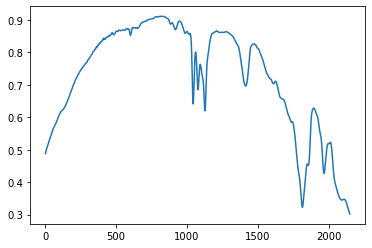

In [53]:
plt.plot(ww)

/Users/ankit/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


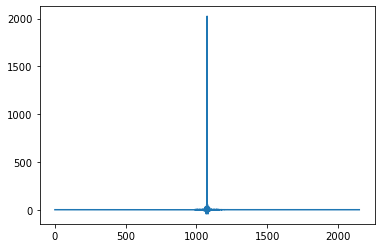

In [66]:
yf = fft(aa[0])
yf
plt.plot(fftshift(yf))

In [54]:
aa = sp.convex_hull_removal(ww,list(range(350,2501)))

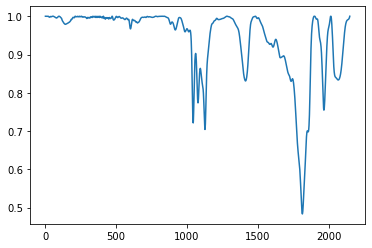

In [55]:
plt.plot(aa[0])

In [250]:
def compute_similarity(ref_rec,input_rec,weightage=[0.33,0.33,0.33]):
    ## Time domain similarity
    ref_time = np.correlate(ref_rec,ref_rec)    
    inp_time = np.correlate(ref_rec,input_rec)
    diff_time = abs(ref_time-inp_time)

    ## Freq domain similarity
    ref_freq = np.correlate(np.fft.fft(ref_rec),np.fft.fft(ref_rec)) 
    inp_freq = np.correlate(np.fft.fft(ref_rec),np.fft.fft(input_rec))
    diff_freq = abs(ref_freq-inp_freq)

    ## Power similarity
    ref_power = np.sum(ref_rec**2)
    inp_power = np.sum(input_rec**2)
    diff_power = abs(ref_power-inp_power)

    return float(weightage[0]*diff_time+weightage[1]*diff_freq+weightage[2]*diff_power)

In [252]:
compute_similarity(np.array(fileListContinumRemoval[6]), np.array(aa[0]))

[78.69853829]
[169280.55586016]
54.89897330451822


55906.670612679336

In [237]:
aa[0]

[1.0,
 0.9935262814778876,
 0.9878433138226025,
 0.9840567004947919,
 0.9814041075737067,
 0.9796774616494033,
 0.9787344547998962,
 0.9778666857183681,
 0.9767323369565216,
 0.9764044471238099,
 0.9769715825439595,
 0.9782988619631479,
 0.9784019634578673,
 0.9778546432287092,
 0.9788168501111377,
 0.9799742545087786,
 0.9809533831421655,
 0.9809244409674686,
 0.980637489336401,
 0.980355472404116,
 0.9804848300045739,
 0.9804104360095239,
 0.9797376639600248,
 0.9787787564574275,
 0.9778356595242775,
 0.9773954157171929,
 0.9772040515386661,
 0.9772555602182125,
 0.9776392787477994,
 0.9781585188856242,
 0.9786696012550047,
 0.9787545447153528,
 0.9795297372060856,
 0.9812537887019477,
 0.9829061769312841,
 0.9847588793890034,
 0.986852108581906,
 0.9880707984242355,
 0.9891833542616701,
 0.9908918945515379,
 0.9919242792636331,
 0.9925537990711106,
 0.9930458970792768,
 0.994040853613197,
 0.995148293464962,
 0.9954442152006115,
 0.9959856064230296,
 0.9967673638006712,
 0.997169114

In [249]:
ref_time

NameError: name 'ref_time' is not defined

In [30]:
len(minIndex)

2